In [1]:
%matplotlib inline
import math
import random 
import time
import unittest

from mcts  import *
from state import AbstractState  as State, AbstractAction as Action
from test  import *

from gomoku_example import *
from maze_unfinished import *
from maze_example import *

# Mini-Pset: Monte Carlo Tree Search for Collaboration
<img src="img/random-xkcd.png"/>

1. [Part 0: Background Information](#part-0)
  1. [Structure of the Mini-Pset](#structure)
  1. [*Monte Carlo* meets *Tree Search*](#monte-carlo-meets-tree-search)
  1. [MCTS Algorithm](#mcts-alg)
1. [Part 1: Introduction to MCTS](#part-1)
  1. [Provided Classes](#part-1-provided-classes) 
  1. [Implement: `select` (10 points)](#selection)
  1. [Implement: `expand` (10 points)](#expansion)
  1. [Implement: `default_rollout_policy` (10 points)](#rollout-policy)
  1. [Implement: `backpropagate` (10 points)](#backpropagate)
  1. [Written Question: *MCTS with Heuristics* (10 points)](#heuristics)
1. [Part 2: MCTS for Collaboration](#part-2)
  1. [Provided Classes](#part-2-provided-classes) 
  1. [Implement: `Reward`, `is_terminal`, `possible_actions`, `take_action` (10 points each)](#maze)
  1. [Written Question: *Optimal Strategy* (5 points)](#written-optimal)
  1. [Written Question: *MCTS Performance* (5 points)](#written-performance)

# Part 0: Background Information <a id="part-0"/>

## Structure of the Mini-Pset <a id="structure"/>
This mini-pset is designed to give you an introduction to Monte Carlo Tree Search (MTCS) as a general planning technique as well as an introduction to using MCTS in a collaborative multi-agent scenario. The grading breakdown for this mini-pset can be seen in the outline above.

**Part 0:** provides an overview of the mini-pset, along with helpful background information regarding MCTS. The MCTS algorithm itself is described in the [MCTS Algorithm](#mcts-alg) section.

**Part 1:** focuses on introducing the core mechanics of MCTS: *Selection*, *Expansion*, *Simulation*, and *Back-Propagation*.  This is achieved by implementing each of these core methods and then exploring the results of MCTS when applied to [Gomoku](https://en.wikipedia.org/wiki/Gomoku).

**Part 2:** focuses on introducing the key sub-routines that allow the MCTS functions from part 1 to be used in a collaborative multi-agent scenario. This is done by applying MCTS to a multi-agent value collection scenario that is inspired by the Kolumbo mission.

Hint: the pset is meant to let you have fun with MCTS algorithm, not to be torturing. Therefore, if you find your code is very long (for example, over 20 lines for a single function), it is time to take a closer look at our hints.

---
## *Monte Carlo* meets *Tree Search* <a id="monte-carlo-meets-tree-search"/>
 <table><tr>
    <td> <img src="img/random-pi-estimate.gif" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="img/random-tree-search.gif" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

Generally speaking, *Monte Carlo* methods are a set of algorithms that use random sampling techniques to estimate the value of unknown parameters. Monte Carlo methods are particularly useful when the state space in question is large enough that brute force enumeration is infeasible. By employing the Law of Large numbers, we know that *“As the number of identically distributed, randomly generated variables increases, their sample mean approaches their theoretical mean.”* This law serves as the basis for Monte Carlo methods. As a simple example, Monte Carlo methods can be used to estimate the mathematical value $\pi$. This is shown in the image above.

Trees on the other hand are a restricted form of a graph that allows us to model a wide variety of decision making processes. Importantly, we can employ search methods over a tree to quickly find the optimal solution, given that the tree is of reasonable size. 

So what happens when we combine both paradigms? One way to think about *Monte Carlo Tree Search* is that the *Monte Carlo* mechanism serves as a method for estimating the value of a particular state in the game, done commonly with a random rollout policy, and the *Tree Search* mechanism uses an exploitation-exploration tradeoff with the value estimate and the visitation count of the node to determine which node to expand next. 

MCTS methods stand out in scenarios when the branching factor is quite high, there are no hand-constructed heuristics available, or an anytime solution is required.  

### Bandit Problems
<img src="img/random-bandit-cartoon.png" alt="Drawing" style="width: 600px;"/>

*Bandit Problems* are a class of sequential decision making problems where an agent must chose between $K$ actions in order to maximize the cumulative reward of the agent for some amount of time horizon.  For example, the agent (the bandit) in the scenario shown in the image above is an octopus, and the possible actions available to the octopus at any point in time correspond to the available slot machine levers. The goal of the octopus is to devise an optimal policy via experimentation because the underlying reward distribution associated with each lever is unknown. This means that the octopus must estimate the potential reward of pulling a particular lever based on the past observations of taking this action. This introduces the **exploitation-exploration dilemma**: the bandit needs to take advantage of the knowledge it has already gained about the system to make choices associated with high rewards, but the bandit must also must consider unexplored actions to learn more about the underlying reward distribution of said action. 

A useful construct for encoding the exploitation-exploration dilemma is **regret**, where regret is the expected loss for the bandit due to not acting optimally.  In this sense, an appropriate strategy for the bandit would be to minimize this regret. To express the regret of the bandit after *n* plays, defined as $R_n$ we can write: 

$$R_n = \mu^*n - \mu_j \Sigma_{j=1}^{K} \mathbb{E}[T_k(n)]$$

where $\mu^*$ is the best possible expected reward and $\mathbb{E}[T_j(n)]$ is the expected number of executions of action $j$ across $n$ trials [[1]](#references). This leads us to the notion of an Upper Confidence Bound (UCB) that a particular action is optimal because UCB suggests a policy to follow in order to minimize the growth of regret for the bandit over time.

### Upper Confidence Bound (UCB)
A useful notion for tackling bandit problems is the upper confidence bound (UCB) that a particular action is the optimal action.  The UCB is useful because it allows the agent to consider both exploitation and exploration when considering what state to explore next. Perhaps the most famous example of a UCB is known as UCB1, shown below. 

$$\text{UCB1} = \bar{X_j} + \sqrt{\frac{2 \text{ln} (n)}{n_j}}$$

The first term, $\bar{X_j}$  represents the current estimated value of action $j$, which improves over time as sampling continues. This serves the exploitation term: when the average value of a particular action is high, we would like to exploit this action in the future. The next term,  $\sqrt{\frac{2 \text{ln} (n)}{n_j}}$ represents the number of times that node $j$ has been sampled relative to its siblings. Here, $n$ is the number of times that node $j$’s parent has been visited in the tree, and $n_j$ is the number of times that node $j$ has been visited. This serves as the exploration term: as the value of $n_j$ relative to $n$ decreases, the UCB value increases, and we are encouraged to explore relatively unexplored states. This version of UCB can readily be extended to include an additional weighting term between the exploration and exploitation terms. We won’t get into the math here, but to summarize, the UCB1 method takes advantage of the Chernoff-Hoeffding inequality to establish provably slow growth of regret for multi-bandit problems [[2]](#references).

---
## MCTS Algorithm <a id="mcts-alg">
    
As discussed in lecture, the MCTS algorithm is a general framework that consists of four key phases: *Selection*, *Expansion*, *Simulation*, and *Back-Propagation*. During the *Selection* and *Expansion* phases, the *Tree Policy* is used, while during the *Simulation* phase, the *Default Policy* is used. The MCTS algorithm allows the *Tree Policy* and *Default Policy* to take on many forms. In this mini-pset, we will focus on using the Upper Confidence Bound for Trees (UCT) to serve as the *Tree Policy* and Random Rollout as the *Default Policy.* Both of these policies are discussed in more detail below.

<img src="img/paper-mcts.png" style="width: 700px;" >

Before we get into UCT and Random Rollout, it is important to remind ourselves of the two fundamental concepts that MCTS is build upon: the value of an action may be approximated by using random simulation, and that these values may be used efficiently to adjust the policy towards a best-first strategy. 

### Upper Confidence Bound for Trees (UCT)
Generally speaking Upper Confidence Bound for Trees (UCT) refers to an MCTS algorithm that utilizes some UCB variant in the tree selection policy. In our case, we will use UCB1 with an added weighting factor as our selection policy. This means that during our selection phase, we select the node with the best UCT value. Keep in mind that the UCT term already includes both exploitation and exploration incentives. Pulling things together, we get the following equation for UCT:

$$\text{UCT} = \bar{X_j} + C_p \sqrt{\frac{2 \text{ln} (n)}{n_j}}$$ 

Again $\bar{X_j}$ is the estimated value of taking action $j$, $n$ is how times the parent node has been visited, $n_j$ is the number of times action $j$ has been taken from this state, and $C_p$ is the additional weighting factor that can toggle the relative importance of the exploitation and exploration terms. If multiple nodes are found to have the same UCT value, the tie is broken by randomly selecting one of the nodes.

The UCT criteria for *Selection* and *Expansion* is what allows for asymmetric tree growth, shown in the figure below. This asymmetric tree growth is why MCTS performs better compared to brute-force exhaustive search and pruning techniques for adversarial games, such as Alpha-Beta pruning, because MCTS will focus its search on promising areas of the tree.

<img src="img/paper-tree-growth.png" style="width: 400px;" >

### Default Policy: Random Rollout 
Once an action has been selected and expanded, it is now time to perform simulation in order to retrieve an estimate for how good (or bad) this particular state is. This is where the *Default Policy* is used to get from the current state to a terminal state. Once at the terminal state, we can assess the value of this simulated version of the game and use back-propagation to share this information up the tree. As mentioned previously, we harness the power of random sampling in our *Default Policy* by employing *Random Rollout*. Random Rollout simply chooses actions randomly from the set of possible actions at a given state until a terminal state is reached. It’s that simple. It is also possible to incorporate some heuristics to guide the behavior of the rollout, but we will not consider heuristics at this time. 

The figure below shows an example of a random rollout for a Tic-Tac-Toe game. Since the blue circle ends up winning the game, they improve the estimated value of the first move that was made. 

<img src="img/random-tree-rollout.png" style="width: 300px;" >



## Fun Example: AlphaGo Zero
Before jumping into the implementation work of this problem set, we quickly mention a recent example of using MCTS to devise the best Go-playing AI system to date: AlphaGo Zero, to help motivate the power of MCTS. AlphaGo Zero three core components: MCTS, Neural Networks, and Reinforcement Learning. The MCTS is used in AlphaGo Zero to determine which node to expand next in the tree, just like how we will utilize MCTS in this mini-pset. However, AlphaGo Zero also uses a Neural Network to assess the value of a state and Reinforcement Learning to update the weights of this Neural Network. Also, AlphaGo Zero had the luxury of playing against itself MANY times (approximately 19.6 million self-play games), on a high-powered machine. That said, MCTS is still the workhorse that pucks out the next move to make. [[3]](#references)
 <table><tr>
    <td> <img src="img/random-go-performance.gif" alt="Drawing" style="width: 500px;"/> </td>
    <td> <img src="img/random-lee-sedol.jpg" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

 ---
# Part 1: Introduction to MCTS <a id="part-1"/>

In Part 1 of the mini-pset, you are asked to implement the four stages of the MCTS algorithm. After validating your code for each of these stages, you can see how your algorithm helps build a Gomoku AI!

The core objective of Gomoku is to get five of your tokens aligned in a row, either horizontally, vertically, or in either diagonal direction. At any given turn during the game, you are allowed to place your token in any free space. The game ends as soon as five-in-a-row is achieved somewhere on the board, and the game is typically played on a 15$\times$15 board. In theorey, if the black side, who moves first, always adopts the optimal strategy, it will always win. As a result, the actual rules in a professional-level Gomoku game is more complicated than this. However, the specific rules regarding how to play Gomoku are not important for the mini-pset because the core mechanics of MCTS are not specific to a particular game or scenario, and we are restricting ourselves to a 9$\times$9 board. To support the simulation of the Gomoku game, we have provided you with `GomokuState` and `GomokuAction` classes that embody the mechanics of the Gomoku game. You will not need to interact with these classes directly because we have well-prepared wrappers for you to call. An example of the Gomoku game is shown below, and your job is to help the black side to win.

<img src="img/gomoku_example_initial_state.png" style="width: 400px;" >
    
---
<div class="alert alert-block alert-warning">
    
## Provided Classes <a id="part-1-provided-classes"/>


You are now asked to finish several key components in Monte Carlo Tree Search, namely the `select`, `expand`, `default_rollout_policy` and `backpropagate` functions. You will need to use the `Node` class that we have provide.

### `Node` Class

`Node` **member variables** (accessible and modifiable via `my_node.children`, etc):
1. `children`: a dictionary that maps `Action` objects to `Node` objects, representing the children of the  node
1. `tot_reward`: a float of reward that has been back-propagated to this node
1. `num_samples`: an int of number of samples that has been back-propagated to this node

`Node` **properties** (accessible but not modifiable via `my_node.state`, etc):
1. `state`: a `State` object corresponding to state of the node
1. `parent`: a `Node` object that is the parent
1. `unused_edges`: a list of `Action` objects that have not contributed to building child nodes (i.e. unexplored actions from this node)
1. `is_terminal`: a bool representing whether or not the `State` object associated with the node is a terminal state
1. `depth`: an int of the depth of the node. The depth of a root node is 1 (the parent of the root node is `None`)
1. `is_expanded`: a bool representing whether all possible actions and associated child nodes have been added to the `children` dictionary

`Node` **methods** (accessible via `my_node.add_child(new_action)`)
1. `add_child(action)`: if `action` is in the list `unused_edges`, then this method builds a new `Node` object called `child`, adds the key-value pair `action`:`child` to the `children` dictionary, and returns returns `child`
</div>



### Hints
- when making random selection from a list of variables, use the `random.choice()` function
- when evalauting the natural log, you can use `math.log()` 

---
## Implement: `select` (10 points) <a id="selection"/>
<img src="img/paper-selection.png" style="width: 700px;" >

The standard way to select a node to expand is based on choosing the node with the maximal upper confidence bound (UCB):
$$UCB=\left(\frac{\text{total_reward}}{\text{number_of_samples_of_the_child_node}}\right)+\sqrt{2\frac{\ln({\text{number_of_samples_of_the_parent_node})}}{\text{number_of_samples_of_the child_node}}}$$
where the first term is the average reward per sample (the exploitation term), and the second term, coming from Hoeffding's inequality, will favor less unexplored choices (the exploration term).

Later when we are choosing the best strategy for the agent (we are actually taking an action in real-life rather than simulating actions in MCTS), we pursue pure exploitation. This means that we need a way to toggle on and off the exploration term. To achieve this, we add an additional term called the “exploration_constant” to the equation, giving us the resulting definition of UCB:

$$UCB=\left(\frac{\text{total_reward}}{\text{number_of_samples_of_the_child_node}}\right)+\text{exploration_constant}*\sqrt{2\frac{\ln({\text{number_of_samples_of_the_parent_node})}}{\text{number_of_samples_of_the child_node}}}$$

Remember to use our [Provided Classes](#part-1-provided-classes) when implementing!

In [2]:
def select(node: Node, exploration_const: float = 1.0) -> (Action, Node):
    """ Select the best child node based on UCB; if there are multiple
        child nodes with the same max UCB, randomly select one
        (using the UCB definition mentioned above with the exploration constant)
    :param node: The parent node
    :param exploration_const: The exploration constant in UCB formula
    :return: an (action, child) tuple representing the best choice in terms of UCB,
             where action is an Action object and child is a Node object
    """
    best_ucb = -math.inf
    best_actions = []
        
    for action, child in node.children.items():
        
        ### BEGIN SOLUTION
        node_ucb = (child.tot_reward / child.num_samples
                    + exploration_const *
                    math.sqrt(2.0 * math.log(node.num_samples) /
                              child.num_samples))
        if node_ucb > best_ucb:
            best_ucb = node_ucb
            best_actions = [action]
        elif node_ucb == best_ucb:
            best_actions.append(action)
        ### END SOLUTION
        
    best_action = random.choice(best_actions)
    return best_action, node.children[best_action]

In [3]:
test_select(select)
test_ok()

Tests passed!!

---
## Implement: `expand` (10 points) <a id="expansion"/>
<img src="img/paper-expansion.png" style="width: 700px;" >
Suppose that you have selected a non-terminal node that has not yet been expanded. As a reminder, a node “terminal” means that we stop simulation, assess the reward that was accumulated, and backpropagate the results along the tree. The `expand` process randomly selects an action from the list of available untaken actions, adds the new child node to the `children` dictionary, and returns the child node.

(As a reminder, a node being “expanded” means that all of the possible actions that can be taken from the node are already in the tree as children of the node. The UCB selection process only considers fully expanded nodes. Once a node is reached that has not yet been “expanded”, the `expand` process is called) 

Remember to use the [Provided Classes](#part-1-provided-classes) when implementing!

In [4]:
def expand(node: Node) -> Node:
    """ Randomly select an untried action and create a child node based on it
        Return the new child node
    :param node: The parent node
    :return: The child node
    """
    if node.is_expanded:
        raise Exception("Should not expand a node that has already been expanded")
        
    ### BEGIN SOLUTION
    action = random.choice(node.unused_edges)
    return node.add_child(action)
    ### END SOLUTION


In [ ]:
test_expand(expand)
test_ok()

Tests passed!!

---
## Implement: `default_rollout_policy` (10 points) <a id="rollout-policy"/>
<img src="img/paper-simulation.png" style="width: 700px;" >

As mentioned in [Part 0](#mcts-alg), the default rollout policy is to randomly select actions from the set of possible actions until a terminal state is reached.

Remember to used the [Provided Classes](#part-1-provided-classes) when implementing!
- `State` objects have a property `is_terminal` to represent whether a it is a terminal state
- `State` objects have a property `possible_actions` which is a list of `Action` objects that are available from the current state.
- `State` objects have a method  `execute_action(action)` which takes an `Action` object as input and returns a copy of the resulting `State` object after taking the action
- `random.choice()` can be used to randomly select an action from a list of actions.

In [ ]:
def default_rollout_policy(state: State) -> float:
    """ The default policy for simulation is to randomly (uniform distribution)
        select an action to update the state and repeat the simulation until
        a terminal state is reached
    :param state: The starting state
    :return: The reward at the terminal state
    """
    ### BEGIN SOLUTION
    while not state.is_terminal:
        action = random.choice(state.possible_actions)
        state = state.execute_action(action)
    return state.reward
    ### END SOLUTION

In [ ]:
test_default_rollout_policy(default_rollout_policy)
test_ok()

Tests passed!!

---
## Implement: `backpropagate` (10 points) <a id="backpropagate"/>
<img src="img/paper-back-propagation.png" style="width: 700px;" >

After simulation is performed and a terminal node is reached, the next thing to do is to update the visit counts and the total reward achieved for relevant nodes. In this case, the relevant nodes are sequence of parent node after parent node until the root node is reached. 

Remember to used the [Provided Classes](#part-1-provided-classes) when implementing!
- `Node` objects have a member property `parent`
- `Node` objects store visit count and total reward at public variables `num_samples` and `tot_reward` respectively

In [ ]:
def backpropagate(node: Node, reward: float = 0.0) -> None:
    """ Propagate the reward and sample count from the specified node
        back all the way to the root node (the node with None as parent)
    :param node: The node where simulation starts
    :param reward: The reward at the terminal state of the simulation
    """
    ### BEGIN SOLUTION
    while node is not None:
        node.num_samples += 1
        node.tot_reward += reward
        node = node.parent
    ### END SOLUTION



In [ ]:
test_backpropagate(backpropagate)
test_ok()

Tests passed!!

---
## Written Question: *MCTS with Heuristics* (10 points) <a id="heuristics"/>

Now that you have implemented the MCTS algorithm, you should be ready to use it run it on the Gomoku problem. The Gomoku game that we provide you with has already been partially played out in order to prevent long run-times on the Jupyter hub. That said, please note that the simulation may take up to 3-5 minutes to complete the game. To ensure that the simulation always terminates in a reasonable number of steps and to make sure that the results observed by everyone are similar, we have fixed the random seed. Also, note that black tokens start off with an advantage, so if they were a good Gomoku player, they should always win. Keep this in mind when you interpret the simulation results. The initial game state is shown below.

<img src="img/gomoku_example_initial_state.png" style="width: 500px;" >

The following two code bocks offer two different simulations that you can test your MCTS algorithm on. The first simulation considers all free board spaces as a possible “next_action”. However, the second simulation only considers the free board spaces that are adjacent to a non-free board space to be part of the set of possible “next_actions”. Essentially, this adjustment serves as a heuristic that biases the search towards adjacent action sequences rather than playing moves randomly across the board. 

Action (player BLACK takes position (4, 3))
Action (player WHITE takes position (4, 2))
Action (player BLACK takes position (5, 3))
Action (player WHITE takes position (5, 2))
Action (player BLACK takes position (4, 0))
Action (player WHITE takes position (3, 2))
Action (player BLACK takes position (6, 2))
Action (player WHITE takes position (1, 2))


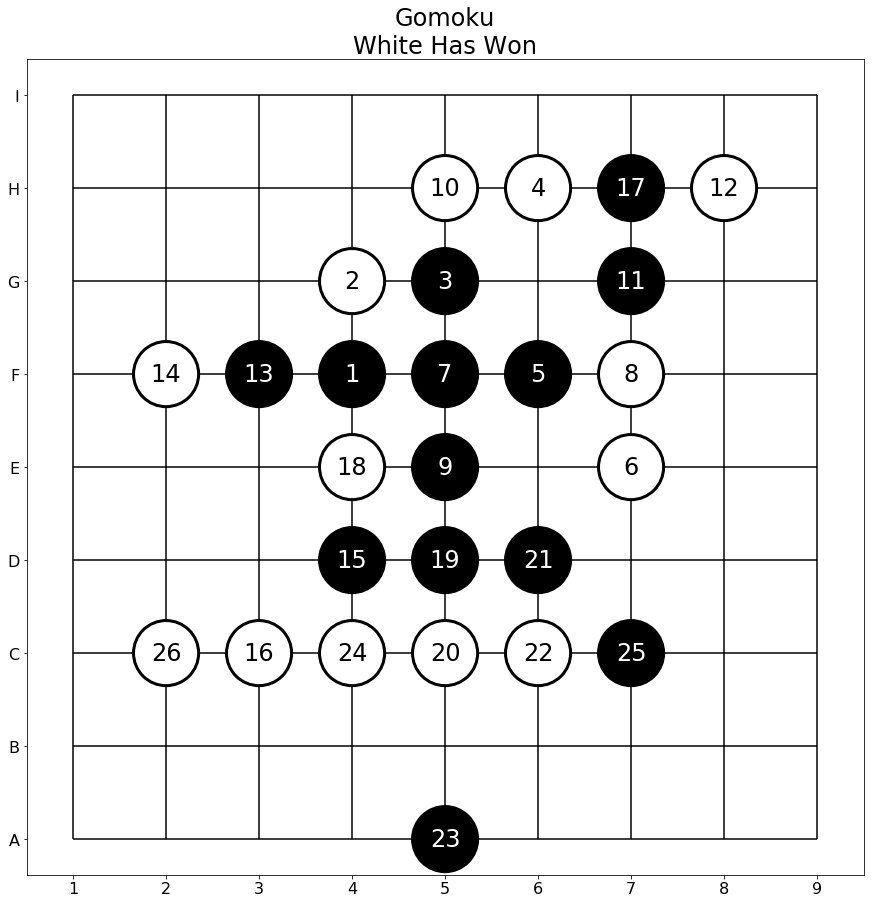

In [ ]:
simulate_with_black_sample_arbitrarily(select_policy=select,
                                       expand_policy=expand,
                                       simulate_policy=default_rollout_policy,
                                       backpropagate_policy=backpropagate,
                                       num_iters=1000)

Action (player BLACK takes position (1, 3))
Action (player WHITE takes position (2, 4))
Action (player BLACK takes position (4, 3))
Action (player WHITE takes position (4, 2))
Action (player BLACK takes position (5, 3))
Action (player WHITE takes position (2, 3))
Action (player BLACK takes position (6, 2))
Action (player WHITE takes position (7, 1))
Action (player BLACK takes position (2, 6))


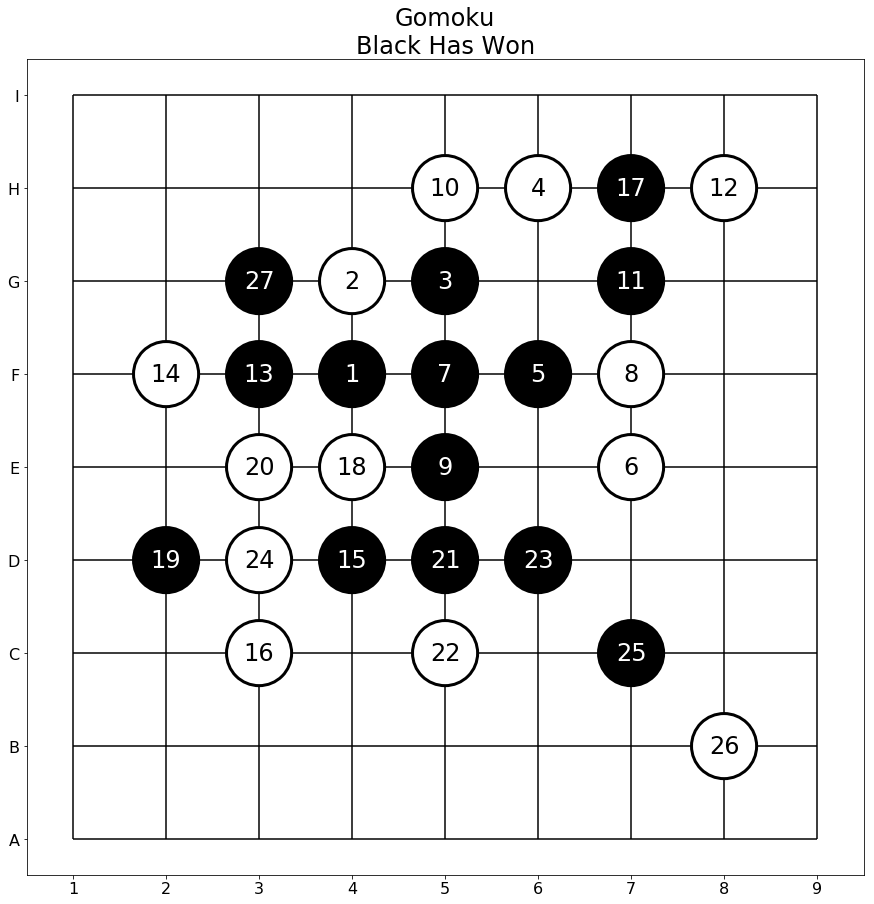

In [ ]:
simulate_with_black_sample_neighborhood(select_policy=select,
                                        expand_policy=expand,
                                        simulate_policy=default_rollout_policy,
                                        backpropagate_policy=backpropagate,
                                        num_iters=1000)

**Note**: Since the simulation is very random when the number of iterations is limited to a smaller value, and it takes quite long to perform a large-sample simulation, we provide everyone with sample results to answer the following question.

## MCTS Team Results for the Gomoku Problem
 
### Simulation 1: Black takes any free space
<img src="img/gomoku_example_simulation_result_black_takes_any_moves.png" style="width: 500px;" >

### Simulation 2:  Black only takes space with occupied neighbors<img src="img/gomoku_example_simulation_result_black_takes_neighboring_moves.png" style="width: 500px;" >

**Question:** Based on the sample results, which strategy generates a better result (the fully random strategy or the heuristic-augmented strategy)? Explain why. Probably you are still not satisfied with your AI, especially when the number of samples is limited. Could you come up with some potential methods to improve the performance of MCTS in Gomoku games?

YOUR ANSWER HERE

---
# Part 2: MCTS for Collaboration <a id="part-2"/>

In Part 1, you have implemented the core MCTS algorithm. In Part 2, you will learn the usage of the MCTS functions that you have already implemented, and how to model a situation that supports multi-agent collaboration. In fact, to apply the MCTS algorithm in Part 1 to any problem, all you need to do is to create a class with member properties `reward`, `is_terminal`, `possible_actions` and member method `execute_action`.

## AUV Reward Collection Problem
Suppose you are given 3 AUVs and your task is to use them to explore valuable locations of an underwater area, which has been spatially discretized into a 2-D grid system. An example of this scenario is shown below:

<img src="img/maze_example_1.png" style="width: 500px;" >

The time-horizon is also discretized into 15 steps. Vehicle dynamics are ignored and the possibility of vehicle-vehicle collisions are ignored. At each time step, an AUV can move to one of the four adjacent tiles in the NSEW cardinal directions (no diagonal transitions are allowed). However, vehicles are not allowed to transition into a tile that contains an obstacle. Obstacles are the red tiles in the visualization. The valued regions are shown as blue circles, with the larger circles representing reward of 3.0 and smaller circles being rewards of 1.0. 

We refer to example above as “Maze Example 1”. The task is to model this problem so that the MCTS functions implemented in Part 1 can be applied; and you will know how we implemented the Gomoku game because they are quite similar (if not but you are interested, you can find the implementation in *gomoku.py*).

---

<div class="alert alert-block alert-warning">
    
## Provided Classes <a id="part-2-provided-classes"/>

We have provided a class `UnfinishedMazeState`, and your job is to finish building the class `MazeState`, which is a subclass of `UnfinishedMazeState` (this means that `MazeState` inherits many of the AUV-specific functions from `UnfinishedMazeState`, but not all of the functions necessary for compatibility with MCTS are implemented yet — your job is to implement these functions) . To be more specific, you need to implement four key properties/methods, namely `is_terminal`, `reward`, `possible_actions` and `execute_action`. We have have provided you with the following classes:

### `MazeAction` Class
`MazeAction` Constructor:
1. `MazeAction(agent_index, position)`: constructs a `MazeAction` object,  where `agent_index` is an int that indicates which AUV should move, and position is an `(int, int)` tuple representing the location the agent is moving toward. 
    - For example `MazeAction(0, (10,10))` would be a `MazeAction` object that represents agent 0 moving to position (10,10). 

`MazeAction` Properties: 
1.  `agent_index` : the index that represents which agent performed this action 
1.  `position`: the position that the agent moved to by taking this action

---
### `MazeEnvironment` Class
`MazeEnvironment`  Properties:
1. `rewards`: a dictionary mapping position of type `(int, int)` to a reward value of type `float`
1. `obstacles`: a set of position locations `(int, int)` , such that every grid cell contained in the `obstacles` set is considered an obstacle

---
### `UnfinishedMazeState` Class
`UnfinishedMazeState` Properties:
1. `paths`: a list of paths, \[`path_0`, `path_1`, `path_2`, $\ldots$\], where each path `path_i` is a list of position tuples `(int, int)` that represent the trajectory of agent `i`. The first `(int,int)` tuple in `path_i` is the initial position of agent `i` and the last `(int, int)` tuple in `path_i` is the current position of agent `i`. pa the last tuple is current position of agent $i$. This property records the trajectories of all agents. 
1. `time_remains`: an int that represents the number of time steps remaining in the problem (this represents the time-horizon constraint that the mission must be completed by *x* time)
1. `visited`: the set of visited position tuples `(int, int)` (the union of the visit locations amongst the multiple agents)
1. `turn`: an int object indicating which agent should move next. It is assumed the first agent is given by `int=0`
1. `environment`: a `MazeEnvironment` object that represents the environment

`UnfinishedMazeState` Methods:
1. `switch_agent()`:  updates the `turn` property to indicate that it is next agents turn. Once all agents have moved for a given time-interval round, then the `time_remains` property would be updated.
1. `is_in_range(position)`: takes in a position tuple `(int, int)` as input and returns a bool, that indicates  whether a position is inside the problem domain.
1. `__copy__()`: returns a copy of the current state. `deepcopy` is applied to necessary member variables.
</div>

## Implement: `reward`, `is_terminal`, `possible_actions`, `execute_action` (10 points each) <a id ="maze">
    
Using the [Provided Classes](#part-2-provided-classes) above, implement the following properties and method:
- `reward`: returns a `float` that represents the total collected reward given the state of the environment. Note that reward is only collected from a location once the location has been visited, and multiple rewards can not be retrieved from the same position.


- `is_terminal`: returns a bool if and only if the the state is terminal. A state is terminal if and only if no time remains.


- `possible_actions`: returns the list of `MazeAction` objects that represent the possible actions that can be taken from this state of the `MazeState`. Note that you are only generating the possible actions for a single agent. To do so, you must consider the following: what agent must take an action next (see [Provided Classes](#part-2-provided-classes) if you do not know), where this agent is currently located, the viable domain of the problem, and the obstacles in the environment.


- `execute_action(maze_action)`: given a `MazeAction` action, executes the action in a separate copy (because when you are doing MCTS, your current state does not really change, so you want to perform simulation on a copy) of the current state and returns that copy after completing the action.  To do so, you must consider the following: the effect of executing this action on the `paths` property of `MazeState`, the effect of executing this action on the `turn` property of `MazeState` (remember that we have already provided a good method to update it), and the effect of executing this action on the `time_remains` property of `MazeState`. 
    
*Note that you can implement these methods sequentially because the test functions only require that the individual functions are correct, not that the entire class is implemented correctly.*

In [ ]:
class MazeState(UnfinishedMazeState):

    def __init__(self, environment: MazeEnvironment, time_remains: int = 10):
        """ Create a state of the AUV reward-collection game
        """
        super().__init__(environment, time_remains)

    @property
    def reward(self) -> float:
        """ The total reward at the current state is value of
            rewards that have been visited by agents
        """
        ### BEGIN SOLUTION
        reward = 0.0
        for target_position in self.environment.rewards:
            if target_position in self.visited:
                reward += self.environment.rewards[target_position]
        return reward
        ### END SOLUTION

    @property
    def is_terminal(self) -> bool:
        """ The only terminal condition is no time remains
        """
        ### BEGIN SOLUTION
        return self.time_remains <= 0
        ### END SOLUTION

    @property
    def possible_actions(self) -> list:
        """ The possible actions based on the current state
            Note that you are only moving a single agent
            In our Provided Classes section, you can find
            which agent you are moving
        """
        ### BEGIN SOLUTION
        i, j = self._paths[self.turn][-1]
        actions = [MazeAction(self.turn, (i + 1, j)),
                   MazeAction(self.turn, (i - 1, j)),
                   MazeAction(self.turn, (i, j + 1)),
                   MazeAction(self.turn, (i, j - 1))]
        return [action for action in actions if
                self.is_in_range(action.position) and
                action.position not in self.environment.obstacles]
        ### END SOLUTION

    def execute_action(self, action: MazeAction) -> "MazeState":
        """ Execute the action based on the current state
            You can assume that the action is always valid
            Be sure to update the agent and time using the information
            we provided in the Provided Class section
        :param action: The action
        :return: The state after being updated
        """
        ### BEGIN SOLUTION
        new_state = self.__copy__()
        new_state.paths[action.agent_index].append(action.position)
        new_state.switch_agent()
        return new_state
        ### END SOLUTION

In [ ]:
test_reward(MazeState)
test_ok()

Tests passed!!

In [ ]:
test_is_terminal(MazeState)
test_ok()

Tests passed!!

In [ ]:
test_possible_actions(MazeState)
test_ok()

Tests passed!!

In [ ]:
test_take_action(MazeState)
test_ok()

Tests passed!!

After your code is validated, you can run the simulation. Note that the simulation would take several minutes and we have fixed the random seed.

In [ ]:
simulate(MonteCarloSearchTree, initial_state=maze_example_1(MazeState),
         mcts_select_policy=select,
         mcts_expand_policy=expand,
         mcts_rollout_policy=default_rollout_policy,
         mcts_backpropagate_policy=backpropagate).visualize()

Time step 1
Action: Agent 0 moves to (8, 7)
Action: Agent 1 moves to (14, 8)
Action: Agent 2 moves to (11, 12)
Time step 2
Action: Agent 0 moves to (8, 8)
Action: Agent 1 moves to (15, 8)
Action: Agent 2 moves to (10, 12)
Time step 3
Action: Agent 0 moves to (8, 7)
Action: Agent 1 moves to (14, 8)
Action: Agent 2 moves to (9, 12)


---
## Written Question: *Optimal Strategy* (5 points) <a id="written-optimal"/>

Now consider a different problem, which we refer to as Maze Example 2, as shown below. In this figure, the largest blue circles have rewards of 10.0, the smallest have 1.0 and the intermediate have 4.0.

<img src="img/maze_example_2.png" style="width: 500px;" >

What is the optimal strategy? You only need to conceptually describe it. There is no need to enter the exact moves for each time steps.

For example:
> The AUV starting at (13, 8) should first collect the reward at (14, 10), (14, 11), and then move towards the reward at (15, 8)
> The AUV starting at (7, 7) should move towards the reward at (11, 2)
> The AUV starting at (12, 12) should move towards the reward at (4, 19)

YOUR ANSWER HERE

---
## Written Question: *MCTS Performance* (5 points) <a id="written-performance"/>

Run the simulation for Maze Example 2. The execution will again take several minutes.

In [ ]:
simulate(MonteCarloSearchTree, initial_state=maze_example_2(MazeState),
         mcts_select_policy=select,
         mcts_expand_policy=expand,
         mcts_rollout_policy=default_rollout_policy,
         mcts_backpropagate_policy=backpropagate).visualize()

**Question:** Does MCTS find the optimal strategy? When using the default rollout policy, do you think MCTS has the ability to find the optimal strategy in Maze Example 2? Explain why.

**Note:** if you had trouble getting the simulation to run, you can refer to the plots shown below under *“MCTS Team Results”*, so you should still be able to answer the question. 

YOUR ANSWER HERE

## MCTS Team Results for the AUV Value Collection Problem
 
### Maze Example 1: <img src="img/maze_example_1_result.png" style="width: 500px;" >

### Maze Example 2: <img src="img/maze_example_2_result.png" style="width: 500px;" >

Congratulations! You have finished a valuable pset where you have learnt how to build a modularized MCTS algorithm, and have practiced how to use it to solve problems!

## References <a id="references">
[1] Browne et. al. 2012, *A Survey of Monte Carlo Tree Search Methods*, IEEE.

[2] Auer et. al. 2001, *Finite-time Analysis of the Multiarmed Bandit Problem*, International Conference on Machine Learning.

[3] Silver et. al. 2017, *Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm*, arXiv.